# Análysis GOES, T and EM

elimina ceros, NaN, repeated T_cor, outliers T_cor

## Packages

In [75]:
from datetime import datetime, timedelta
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
#import plotly.express as px

## Functions

In [76]:
# formato para ejes logarítmico
def log_decimal_format(x, pos):
    """Formateador para el eje logarítmico (usa notación decimal)"""
    if x == 0:
        return "0"
    else:
        exp = int(np.floor(np.log10(x)))
        base = x / 10**exp
        if base == 1:
            return f"10$^{{{exp}}}$"
        else:
            return f"{base:.1f}×10$^{{{exp}}}$"

# Gráfica de EM vs T
def plot_em_vs_t(df_full,
                 EM="EM_cor_norm",
                 T="T_cor",
                 color_by=None,           # e.g. "observatory", "Class", etc.
                 palette="viridis",
                 graphics_dir=None,
                 title_suffix="todos los datos"):
    """
    Grafica EM vs T para todo el DataFrame (sin usar flares ni tiempos).
    Eje X: EM
    Eje Y: T
    """

    # Verificar columnas
    for col in [EM, T]:
        if col not in df_full.columns:
            raise ValueError(f"La columna '{col}' no está en el DataFrame.")

    # Asignar colores
    if color_by and color_by in df_full.columns:
        labels = sorted(df_full[color_by].dropna().unique())
        cmap = plt.get_cmap(palette, len(labels))
        class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = df_full[color_by].map(class_to_color)
    else:
        colors = "blue"
        labels = []

    # Configuración
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 15,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 15
    })

    # --- Crear figura ---
    plt.figure(figsize=(8, 6))
    plt.scatter(df_full[EM], df_full[T], c=colors, alpha=0.6, s=10)
    plt.xscale("log")
    plt.xlabel(r"EM$_{49}$ [cm$^{-3}$]")
    plt.ylabel("Temperatura [MK]")
    plt.title(f"T vs EM ({title_suffix})", pad=20)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.xlim(df_full[EM].min()*0.8, df_full[EM].max()*1.2)
    plt.ylim(0, 30)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(log_decimal_format))

    # --- Leyenda (opcional) ---
    if color_by and len(labels) > 0:
        handles = [plt.Line2D([], [], marker="o", color=plt.get_cmap(palette)(i), linestyle="", 
                              label=str(lab)) for i, lab in enumerate(labels)]
        plt.legend(handles=handles, title=color_by, loc="upper left", frameon=False)

    # --- Guardar figura ---
    if graphics_dir:
        os.makedirs(graphics_dir, exist_ok=True)
        output_path = os.path.join(graphics_dir, f"T_vs_EM_{title_suffix}.png")
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Gráfica guardada en: {output_path}")

    plt.show()

# intento 3D
def plot_3d_em_t_time_interactive_html(
    df_full,
    time_col="date",
    EM="EM_cor_norm",
    T="T_cor",
    color_by="xrsb_corr",
    StartTime=None,
    EndTime=None,
    title_suffix="interactivo",
    output_dir=".",
    palette="plasma"   # <- parámetro agregado
):
    """
    Gráfica 3D interactiva (Plotly) y guarda como HTML:
      - X: tiempo
      - Y: EM
      - Z: T
      - Color: color_by (opcional)
      - StartTime/EndTime: filtra por rango temporal si se indica
      - output_dir: carpeta donde guardar el HTML
      - palette: nombre de la paleta de color para color_by
    """

    # --- Preparar DataFrame ---
    df = df_full.copy()
    if time_col not in df.columns:
        raise ValueError(f"La columna {time_col} no está en el DataFrame.")
    
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col, EM, T])
    
    # --- Filtrar por rango temporal ---
    if StartTime:
        df = df[df[time_col] >= pd.to_datetime(StartTime)]
    if EndTime:
        df = df[df[time_col] <= pd.to_datetime(EndTime)]
    
    if df.empty:
        print("⚠️ No hay datos en el rango especificado.")
        return
    
    # --- Crear figura ---
    fig = px.scatter_3d(
        df,
        x=time_col,
        y=EM,
        z=T,
        color=color_by if color_by in df.columns else None,
        color_continuous_scale=palette,
        opacity=0.7,
        title=f"Evolución 3D de T vs EM vs Tiempo ({title_suffix})",
        labels={
            time_col: "Tiempo",
            EM: "EM [cm⁻³]",
            T: "Temperatura [MK]",
            color_by: color_by
        }
    )
    
    fig.update_layout(
        scene=dict(
            yaxis_type="log",
            zaxis=dict(range=[0,30]),
            xaxis_title="Tiempo",
            yaxis_title="EM [cm⁻³]",
            zaxis_title="Temperatura [MK]"
        ),
        margin=dict(l=0, r=0, b=0, t=50)
    )
    
    # --- Guardar en HTML ---
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f"3D_plot_{title_suffix}.html")
    fig.write_html(output_file)
    print(f"✅ Gráfica guardada en: {output_file}")

# Gráfica 
def plot_xrs_vs_te_from_df_full(df_full,
                                days=None,
                                XRS="xrsb_corr",
                                T="T_cor",
                                EM="EM_cor_norm",
                                color_by=None,       # "Class", "Date", "Observatory" o None
                                palette="viridis",
                                graphics_dir=None):
    """
    Grafica directamente todas las filas del DataFrame:
      - XRS vs EM
      - XRS vs T
    sin usar datos de flares (usa todo el dataset filtrado).
    """

    # Verificar que las columnas existen
    for col in [XRS, T, EM]:
        if col not in df_full.columns:
            raise ValueError(f"La columna '{col}' no está en el DataFrame.")

    # Asignar colores
    if color_by and color_by in df_full.columns:
        labels = sorted(df_full[color_by].dropna().unique())
        cmap = plt.get_cmap(palette, len(labels))
        class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = df_full[color_by].map(class_to_color)
    else:
        colors = "blue"
        labels = []

    # Configuración de estilo
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 15,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # --- Panel 1: XRS vs EM ---
    axes[0].scatter(df_full[EM], df_full[XRS], c=colors, alpha=0.6, s=10)
    axes[0].set_xlabel(r"EM$_{49}$ [cm$^{-3}$]")
    axes[0].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[0].set_title(f"{XRS} vs {EM} ({days or 'todos'} días)", pad=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlim(0.001, None)
    axes[0].xaxis.set_major_formatter(FuncFormatter(log_decimal_format))
    axes[0].grid(True, which='both', linestyle='--', alpha=0.5)

    # --- Panel 2: XRS vs T ---
    axes[1].scatter(df_full[T], df_full[XRS], c=colors, alpha=0.6, s=10)
    axes[1].set_xlabel(f"{T} [MK]")
    axes[1].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[1].set_title(f"{XRS} vs {T} ({days or 'todos'} días)", pad=20)
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, 30)
    axes[1].grid(True, which='both', linestyle='--', alpha=0.5)

    # --- Leyenda (si aplica) ---
    if color_by and len(labels) > 0:
        handles = [plt.Line2D([], [], marker="o", color=plt.get_cmap(palette)(i), linestyle="", 
                              label=str(lab)) for i, lab in enumerate(labels)]
        fig.legend(handles=handles, title=color_by, loc="upper center",
                   bbox_to_anchor=(0.5, -0.02), ncol=len(labels),
                   frameon=False, title_fontsize=17)

    # --- Guardar figura ---
    if graphics_dir:
        os.makedirs(graphics_dir, exist_ok=True)
        output_name = f"{days or 'all'}d_{XRS}_vs_{T}_{EM}_full_dataset.png"
        output_path = os.path.join(graphics_dir, output_name)
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Gráfica guardada en: {output_path}")

    plt.show()

def plot_xrs_vs_te_from_df(df_full, df_flares, 
                           days=None,
                           time_column="PeakTime",
                           XRS="xrsb_corr", 
                           T="T_cor", 
                           EM="EM_cor_norm",
                           color_by=None,      # "Class", "Date" o "Observatory"
                           palette="viridis",  
                           class_to_color=None, 
                           graphics_dir=None):
    """
    Versión adaptada para DataFrames en memoria.
    Genera las gráficas:
      - XRS vs EM
      - XRS vs T
    """

    # Asegurar que los índices de df_full sean fechas
    if not np.issubdtype(df_full.index.dtype, np.datetime64):
        if 'date' in df_full.columns:
            df_full = df_full.set_index('date')
        else:
            raise ValueError("df_full debe tener un índice o columna de fechas.")

    # Verificar que las columnas existen
    for col in [XRS, T, EM]:
        if col not in df_full.columns:
            raise ValueError(f"La columna '{col}' no está en df_full")

    # Verificar que el DataFrame de flares tiene la columna de tiempo
    if time_column not in df_flares.columns:
        raise ValueError(f"df_flares debe contener la columna '{time_column}'")

    xrs_vals, em_vals, t_vals, flare_labels = [], [], [], []

    # --- Buscar coincidencias por tiempo ---
    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]
        if flare_time not in df_full.index:
            continue
        flare_row = df_full.loc[flare_time]
        xrs_vals.append(flare_row[XRS])
        t_vals.append(flare_row[T])
        em_vals.append(flare_row[EM])

        if color_by == "Class":
            flare_labels.append(str(flare.get("Class", ""))[0])   # solo letra B,C,M,X
        elif color_by == "Date":
            flare_labels.append(flare_time.date())
        elif color_by == "Observatory" and "observatory" in df_full.columns:
            flare_labels.append(flare_row["observatory"])
        else:
            flare_labels.append("")

    # --- Colores ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # --- Estilo ---
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 15,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    # --- Subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # Panel 1: XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7)
    axes[0].set_xlabel(r"EM$_{49}$ [cm$^{-3}$]")
    axes[0].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[0].set_title(f"{XRS} vs {EM} ({time_column})", pad=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlim(0.001, None)
    axes[0].xaxis.set_major_formatter(FuncFormatter(log_decimal_format))

    # Panel 2: XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7)
    axes[1].set_xlabel(f"{T} [MK]")
    axes[1].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[1].set_title(f"{XRS} vs {T} ({time_column})", pad=20)
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, 30)

    # --- Leyenda ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab)) for lab in labels]
        fig.legend(handles=handles, title=color_by, loc="upper center",
                   bbox_to_anchor=(0.5, -0.02), ncol=len(labels),
                   frameon=False, title_fontsize=17)

    # --- Guardar figura ---
    if graphics_dir:
        os.makedirs(graphics_dir, exist_ok=True)
        output_name = f"{days or 'N'}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by or 'none'}.png"
        output_path = os.path.join(graphics_dir, output_name)
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Gráfica guardada en: {output_path}")

    plt.show()

## Parameters

In [77]:
n=185
# nuevo número de días
new_n = 148
fecha_actual = "2025-11-11"

## Folder of Cleaned Data:

In [78]:
# Folder Name
output_dir = f"Data_for_{n}_days"

# Path of cleaned data in csv
csv_path_full = f"{output_dir}/all_df_full_{new_n}_cleaned.csv"
# Verificar existencia de archivos y avisar
if not os.path.exists(csv_path_full):
    print(f"⚠️ No se encontró el archivo GOES: {csv_path_full}")
else:
    print(f"✅ Archivo GOES encontrado: {csv_path_full}")
df_full_clean = pd.read_csv(csv_path_full)


✅ Archivo GOES encontrado: Data_for_185_days/all_df_full_148_cleaned.csv


## Folder Data GOES Analysis

In [79]:
# Carpeta principal donde se guardarán las gráficas
GOES_graphics_dir = os.path.join(f"GOES_analysis_graphs_{new_n}")

# Crear carpeta si no existe y avisar
if not os.path.exists(GOES_graphics_dir):
    os.makedirs(GOES_graphics_dir)
    print(f"Carpeta creada: {GOES_graphics_dir}")
else:
    print(f"La carpeta ya existía: {GOES_graphics_dir}")

La carpeta ya existía: GOES_analysis_graphs_148


## GOES data inspection

### General Info

In [80]:
df_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213120 entries, 0 to 213119
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date          213120 non-null  object 
 1   observatory   213120 non-null  object 
 2   xrsa          212947 non-null  float64
 3   xrsb          212947 non-null  float64
 4   xrsa_corr     79453 non-null   float64
 5   xrsb_corr     75125 non-null   float64
 6   T_cor         212826 non-null  float64
 7   EM_cor        75125 non-null   float64
 8   T_phot        212826 non-null  float64
 9   EM_phot       75125 non-null   float64
 10  EM_cor_norm   75125 non-null   float64
 11  EM_phot_norm  75125 non-null   float64
 12  day           213120 non-null  object 
 13  GOES_missing  213120 non-null  bool   
dtypes: bool(1), float64(10), object(3)
memory usage: 21.3+ MB


In [81]:
# cambio nombre de la columna fecha y convertimos a datatime
#df_full_clean = df_full_clean.rename(columns={'Unnamed: 0': 'date'})
df_full_clean['date'] = pd.to_datetime(df_full_clean['date'], errors='coerce')


In [82]:
df_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213120 entries, 0 to 213119
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          213120 non-null  datetime64[ns]
 1   observatory   213120 non-null  object        
 2   xrsa          212947 non-null  float64       
 3   xrsb          212947 non-null  float64       
 4   xrsa_corr     79453 non-null   float64       
 5   xrsb_corr     75125 non-null   float64       
 6   T_cor         212826 non-null  float64       
 7   EM_cor        75125 non-null   float64       
 8   T_phot        212826 non-null  float64       
 9   EM_phot       75125 non-null   float64       
 10  EM_cor_norm   75125 non-null   float64       
 11  EM_phot_norm  75125 non-null   float64       
 12  day           213120 non-null  object        
 13  GOES_missing  213120 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(10), object(2)
memory usage: 

In [83]:
# verificar resolución de 1 min
diffs = df_full_clean['date'].diff().dropna()
print(diffs.value_counts().head())


date
0 days 00:01:00    213003
1 days 00:01:00        17
2 days 00:01:00        14
5 days 00:01:00         5
3 days 00:01:00         4
Name: count, dtype: int64


In [84]:
df_full_clean.head()


,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,day,GOES_missing
0,2000-06-06 00:00:00,GOES-16,8.420881e-09,8.545994e-07,0.0,0.0,3.269362,0.0,2.993372,0.0,0.0,0.0,2000-06-06,False
1,2000-06-06 00:01:00,GOES-16,8.207330e-09,8.517512e-07,0.0,0.0,3.269362,0.0,2.993372,0.0,0.0,0.0,2000-06-06,False
2,2000-06-06 00:02:00,GOES-16,8.081609e-09,8.529704e-07,0.0,0.0,3.269362,0.0,2.993372,0.0,0.0,0.0,2000-06-06,False
3,2000-06-06 00:03:00,GOES-16,9.358305e-09,8.624797e-07,0.0,0.0,3.269362,0.0,2.993372,0.0,0.0,0.0,2000-06-06,False
4,2000-06-06 00:04:00,GOES-16,1.116054e-08,8.772037e-07,0.0,0.0,3.269362,0.0,2.993372,0.0,0.0,0.0,2000-06-06,False


### Statistics

In [85]:
df_full_clean.describe()

,date,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
count,213120,2.129470e+05,2.129470e+05,7.945300e+04,7.512500e+04,2.128260e+05,7.512500e+04,2.128260e+05,7.512500e+04,75125.000000,75125.000000
mean,2013-06-22 15:43:17.027026944,1.794786e-06,1.090088e-05,1.137926e-06,4.196651e-06,4.649619e+03,6.195266e+48,4.997748e+02,1.738152e+49,0.619527,1.738152
min,2000-06-06 00:00:00,1.000000e-09,1.000000e-09,0.000000e+00,0.000000e+00,1.329261e+00,0.000000e+00,1.297655e+00,0.000000e+00,0.000000,0.000000
25%,2003-09-17 17:59:45,3.195294e-08,1.547855e-06,2.486769e-09,3.585546e-08,2.795147e+00,6.874552e+46,2.637235e+00,1.904047e+47,0.006875,0.019040
50%,2013-11-01 23:59:30,8.409208e-08,2.823925e-06,1.033456e-08,1.383905e-07,2.811526e+00,2.057457e+47,2.645967e+00,5.828180e+47,0.020575,0.058282
75%,2024-02-11 11:59:15,2.937005e-07,5.879234e-06,5.495166e-08,5.619963e-07,3.269362e+00,6.126541e+47,2.993372e+00,1.771342e+48,0.061265,0.177134
max,2025-06-19 23:59:00,7.807088e-04,2.629195e-03,7.713941e-04,2.488573e-03,6.407996e+08,5.440151e+52,3.779645e+07,1.300871e+53,5440.151319,13008.706378
std,NaN,1.576999e-05,5.221750e-05,1.337437e-05,3.893634e-05,1.422058e+06,2.363674e+50,1.190863e+05,6.012422e+50,23.636740,60.124217


### Check error values

In [86]:
# Total number of numeric values in the dataset
total_values = df_full_clean.select_dtypes(include='number').size
print(f"Total numeric values in dataset: {total_values}\n")

Total numeric values in dataset: 2131200



In [87]:
# Check for negative values
print("🔍 Checking for negative values in numeric columns...")
negative_mask = df_full_clean.select_dtypes(include='number') < 0
negative_any = negative_mask.any()
negative_sum = negative_mask.sum()
total_negatives = negative_sum.sum()
percent_negatives = (total_negatives / total_values * 100).round(3)
print("Columns with negative values:\n", negative_any)
print("Total number of negative values per column:\n", negative_sum)
print(f"➡️ Total negatives: {total_negatives} of {total_values} ({percent_negatives}%)\n")



🔍 Checking for negative values in numeric columns...
Columns with negative values:
 xrsa            False
xrsb            False
xrsa_corr       False
xrsb_corr       False
T_cor           False
EM_cor          False
T_phot          False
EM_phot         False
EM_cor_norm     False
EM_phot_norm    False
dtype: bool
Total number of negative values per column:
 xrsa            0
xrsb            0
xrsa_corr       0
xrsb_corr       0
T_cor           0
EM_cor          0
T_phot          0
EM_phot         0
EM_cor_norm     0
EM_phot_norm    0
dtype: int64
➡️ Total negatives: 0 of 2131200 (0.0%)



In [88]:
# Check for zero values
print("🔍 Checking for zero values in numeric columns...")
zero_mask = df_full_clean.select_dtypes(include='number') == 0
zero_any = zero_mask.any()
zero_sum = zero_mask.sum()
total_zeros = zero_sum.sum()
percent_zeros = (total_zeros / total_values * 100).round(3)

print("Columns with zero values:\n", zero_any)
print("Total number of zero values per column:\n", zero_sum)
print(f"➡️ Total zeros: {total_zeros} of {total_values} ({percent_zeros}%)\n")


🔍 Checking for zero values in numeric columns...
Columns with zero values:
 xrsa            False
xrsb            False
xrsa_corr        True
xrsb_corr        True
T_cor           False
EM_cor           True
T_phot          False
EM_phot          True
EM_cor_norm      True
EM_phot_norm     True
dtype: bool
Total number of zero values per column:
 xrsa               0
xrsb               0
xrsa_corr       2815
xrsb_corr       1529
T_cor              0
EM_cor          1529
T_phot             0
EM_phot         1529
EM_cor_norm     1529
EM_phot_norm    1529
dtype: int64
➡️ Total zeros: 10460 of 2131200 (0.491%)



In [89]:
# Check for NaN values
print("🔍 Checking for missing (NaN) values...")
nan_mask = df_full_clean.isna()
nan_any = nan_mask.any()
nan_sum = nan_mask.sum()
total_nans = nan_sum.sum()
percent_nans = (total_nans / (df_full_clean.shape[0] * df_full_clean.shape[1]) * 100).round(3)

print("Columns with NaN values:\n", nan_any)
print("Total number of NaN values per column:\n", nan_sum)
print(f"➡️ Total NaN values: {total_nans} of {df_full_clean.shape[0] * df_full_clean.shape[1]} ({percent_nans}%)\n")

# Percentage of NaN values by column
nan_percentage = (nan_sum / len(df_full_clean) * 100).round(2)
print("Percentage of NaN values per column (%):\n", nan_percentage)


🔍 Checking for missing (NaN) values...
Columns with NaN values:
 date            False
observatory     False
xrsa             True
xrsb             True
xrsa_corr        True
xrsb_corr        True
T_cor            True
EM_cor           True
T_phot           True
EM_phot          True
EM_cor_norm      True
EM_phot_norm     True
day             False
GOES_missing    False
dtype: bool
Total number of NaN values per column:
 date                 0
observatory          0
xrsa               173
xrsb               173
xrsa_corr       133667
xrsb_corr       137995
T_cor              294
EM_cor          137995
T_phot             294
EM_phot         137995
EM_cor_norm     137995
EM_phot_norm    137995
day                  0
GOES_missing         0
dtype: int64
➡️ Total NaN values: 824576 of 2983680 (27.636%)

Percentage of NaN values per column (%):
 date             0.00
observatory      0.00
xrsa             0.08
xrsb             0.08
xrsa_corr       62.72
xrsb_corr       64.75
T_cor           

In [90]:
df_full_clean[df_full_clean.isna().any(axis=1)].head(7)


,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,day,GOES_missing
10,2000-06-06 00:10:00,GOES-16,1.197625e-08,8.998305e-07,NaN,1.380715e-08,3.269362,2.025745e+47,2.993372,7.272527e+47,0.020257,0.072725,2000-06-06,False
18,2000-06-06 00:18:00,GOES-16,3.568256e-08,1.193076e-06,NaN,1.540050e-07,3.269362,2.259516e+48,2.993372,8.111776e+48,0.225952,0.811178,2000-06-06,False
19,2000-06-06 00:19:00,GOES-16,3.450061e-08,1.188805e-06,NaN,NaN,3.269362,NaN,2.993372,NaN,NaN,NaN,2000-06-06,False
20,2000-06-06 00:20:00,GOES-16,3.859797e-08,1.222848e-06,NaN,NaN,3.269362,NaN,2.993372,NaN,NaN,NaN,2000-06-06,False
21,2000-06-06 00:21:00,GOES-16,4.157288e-08,1.260835e-06,NaN,3.493028e-09,3.269362,5.124869e+46,2.993372,1.839854e+47,0.005125,0.018399,2000-06-06,False
22,2000-06-06 00:22:00,GOES-16,4.139695e-08,1.284487e-06,NaN,6.117068e-08,3.269362,8.974783e+47,2.993372,3.221992e+48,0.089748,0.322199,2000-06-06,False
39,2000-06-06 00:39:00,GOES-16,2.721366e-07,3.985180e-06,NaN,6.927530e-07,3.269362,1.016387e+49,2.993372,3.648880e+49,1.016387,3.648880,2000-06-06,False


In [91]:
1.420684e-08 - 2.401200e-08	

-9.80516e-09

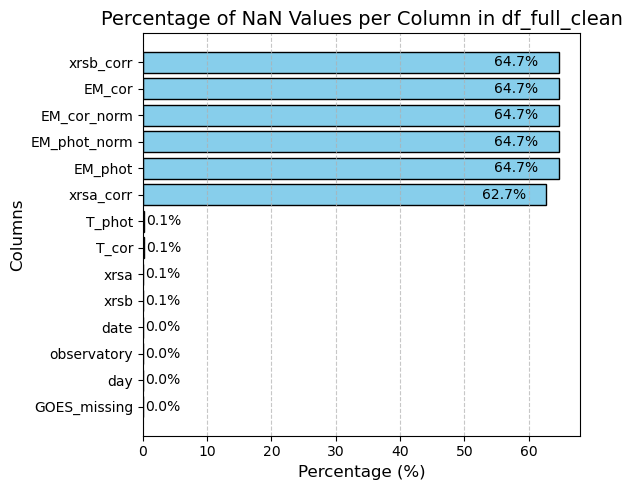

In [92]:
# Calculate percentage of NaN per column
nan_percent = (df_full_clean.isna().sum() / len(df_full_clean)) * 100
nan_percent = nan_percent.sort_values(ascending=False)

# Create figure
plt.figure(figsize=(6, 5))
bars = plt.barh(nan_percent.index, nan_percent, color='skyblue', edgecolor='black')

# Customize appearance
plt.title('Percentage of NaN Values per Column in df_full_clean', fontsize=14)
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Columns', fontsize=12)
plt.gca().invert_yaxis()  # highest NaN percentage at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display percentage values inside or outside each bar
for bar, v in zip(bars, nan_percent):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    
    # If the bar is long enough, place label inside; otherwise, place outside
    if width > 5:
        plt.text(width - (width * 0.05), y_pos, f"{v:.1f}%", 
                 va='center', ha='right', color='black', fontsize=10)
    else:
        plt.text(width + 0.3, y_pos, f"{v:.1f}%", 
                 va='center', ha='left', color='black', fontsize=10)

plt.tight_layout()
plt.show()

In [93]:
# Total number of rows
total = len(df_full_clean)

# 1️⃣ Rows with missing xrsa or xrsb
missing_base = df_full_clean[df_full_clean[['xrsa', 'xrsb']].isna().any(axis=1)]
n_missing_base = len(missing_base)

# 2️⃣ Rows with valid xrsa and xrsb
valid_base = df_full_clean[df_full_clean[['xrsa', 'xrsb']].notna().all(axis=1)]
n_valid_base = len(valid_base)

# 3️⃣ Among valid rows, how many have corrected data in xrsa_corr and xrsb_corr
valid_corr = valid_base[valid_base[['xrsa_corr', 'xrsb_corr']].notna().all(axis=1)]
n_valid_corr = len(valid_corr)

# 4️⃣ Rows without corrected data
n_missing_corr = n_valid_base - n_valid_corr

# 5️⃣ Calculate percentages
p_missing_base = n_missing_base / total * 100
p_valid_base = n_valid_base / total * 100
p_valid_corr = n_valid_corr / total * 100

# 6️⃣ Show summary
print(f"Total rows: {total:,}")
print(f" - Rows missing xrsa and/or xrsb: {n_missing_base:,} ({p_missing_base:.2f}%)")
print(f" - Rows with valid xrsa and xrsb: {n_valid_base:,} ({p_valid_base:.2f}%)")
print(f"   - Of these, with corrections (xrsa_corr and xrsb_corr): {n_valid_corr:,} ({p_valid_corr:.2f}% of total)")
print(f"   - Without corrections: {n_missing_corr:,} ({n_missing_corr/n_valid_base*100:.2f}% of valid rows)")
print(f"\nWe would keep {n_valid_corr:,} rows, representing {p_valid_corr:.2f}% of the total dataset.\n")

# 7️⃣ Inform about removing zeros and NaN
# Count zeros and NaN in numeric columns
numeric_cols = df_full_clean.select_dtypes(include='number').columns
zero_count = (df_full_clean[numeric_cols] == 0).sum().sum()
nan_count = df_full_clean[numeric_cols].isna().sum().sum()
total_numeric = df_full_clean[numeric_cols].size

remaining = total_numeric - zero_count - nan_count
percent_remaining = remaining / total_numeric * 100

print(f"⚠️ We will remove zero and NaN values from numeric columns:")
print(f" - Total numeric values: {total_numeric:,}")
print(f" - Zero values: {zero_count:,}")
print(f" - NaN values: {nan_count:,}")
print(f" - Remaining values after removal: {remaining:,} ({percent_remaining:.2f}%)")


Total rows: 213,120
 - Rows missing xrsa and/or xrsb: 173 (0.08%)
 - Rows with valid xrsa and xrsb: 212,947 (99.92%)
   - Of these, with corrections (xrsa_corr and xrsb_corr): 63,960 (30.01% of total)
   - Without corrections: 148,987 (69.96% of valid rows)

We would keep 63,960 rows, representing 30.01% of the total dataset.

⚠️ We will remove zero and NaN values from numeric columns:
 - Total numeric values: 2,131,200
 - Zero values: 10,460
 - NaN values: 824,576
 - Remaining values after removal: 1,296,164 (60.82%)


## Filter

### Filter 1. Zeros

In [94]:
# Columns to check for zeros
cols_to_check = ['xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr']

# 1️⃣ Count total rows before removal
total_rows = len(df_full_clean)
print(f"Total rows before removing zeros: {total_rows:,}")

# 2️⃣ Identify rows that have zero in any of the columns
zero_rows_mask = (df_full_clean[cols_to_check] == 0).any(axis=1)
n_zero_rows = zero_rows_mask.sum()
print(f"Rows with zero in {cols_to_check}: {n_zero_rows:,}")

# 3️⃣ Remove those rows
df_no_zeros = df_full_clean[~zero_rows_mask]
remaining_rows = len(df_no_zeros)

# 4️⃣ Show summary
percent_removed = round(n_zero_rows / total_rows * 100, 2)
percent_remaining = round(remaining_rows / total_rows * 100, 2)

print(f"✅ Rows removed: {n_zero_rows:,} ({percent_removed}%)")
print(f"Rows remaining: {remaining_rows:,} ({percent_remaining}%)")

Total rows before removing zeros: 213,120
Rows with zero in ['xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr']: 3,196
✅ Rows removed: 3,196 (1.5%)
Rows remaining: 209,924 (98.5%)


In [95]:
df_no_zeros

,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,day,GOES_missing
5,2000-06-06 00:05:00,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513,2000-06-06,False
6,2000-06-06 00:06:00,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867,2000-06-06,False
7,2000-06-06 00:07:00,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856,2000-06-06,False
8,2000-06-06 00:08:00,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692,2000-06-06,False
9,2000-06-06 00:09:00,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455,2000-06-06,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213115,2025-06-19 23:55:00,GOES-18,1.079051e-05,5.694359e-05,NaN,NaN,2.825434,NaN,2.648176,NaN,NaN,NaN,2025-06-19,False
213116,2025-06-19 23:56:00,GOES-18,8.770768e-06,4.779724e-05,NaN,NaN,2.825434,NaN,2.648176,NaN,NaN,NaN,2025-06-19,False
213117,2025-06-19 23:57:00,GOES-18,7.647589e-06,4.319026e-05,NaN,NaN,2.825434,NaN,2.648176,NaN,NaN,NaN,2025-06-19,False
213118,2025-06-19 23:58:00,GOES-18,7.025087e-06,4.140915e-05,NaN,NaN,2.825434,NaN,2.648176,NaN,NaN,NaN,2025-06-19,False


In [96]:
# Filas donde xrsa y xrsb son válidos pero T_cor es NaN
mask = df_no_zeros[['xrsa', 'xrsb']].notna().all(axis=1) & df_no_zeros['T_cor'].isna()
rows_with_issue = df_no_zeros[mask]

# Número de filas
n_rows_issue = len(rows_with_issue)
print(f"Number of rows where 'xrsa' and 'xrsb' are valid but 'T_cor' is NaN: {n_rows_issue}")

# Opcional: ver las primeras filas problemáticas
rows_with_issue.head()

Number of rows where 'xrsa' and 'xrsb' are valid but 'T_cor' is NaN: 122


,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,day,GOES_missing
6881,2000-07-12 18:41:00,GOES-16,8.703582e-07,0.000009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-12,False
6882,2000-07-12 18:42:00,GOES-16,1.414621e-06,0.000011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-12,False
6883,2000-07-12 18:43:00,GOES-16,2.484886e-06,0.000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-12,False
6884,2000-07-12 18:44:00,GOES-16,4.304650e-06,0.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-12,False
6885,2000-07-12 18:45:00,GOES-16,7.822816e-06,0.000030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-12,False


In [97]:
# Filas donde xrsa y xrsb son válidos pero T_cor es NaN
mask = df_no_zeros[['xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr']].notna().all(axis=1) & df_no_zeros['T_cor'].isna()
rows_with_issue = df_no_zeros[mask]

# Número de filas
n_rows_issue = len(rows_with_issue)
print(f"Number of rows where 'xrsa','xrsb', 'xrsa_corr' and 'xrsb_corr' are valid but 'T_cor' is NaN: {n_rows_issue}")

# Opcional: ver las primeras filas problemáticas
rows_with_issue.head()

Number of rows where 'xrsa','xrsb', 'xrsa_corr' and 'xrsb_corr' are valid but 'T_cor' is NaN: 0


,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,day,GOES_missing


### Filter 2. NaN

In [98]:
# Columns to check for NaN (all except 'date' and 'observatory')
cols_to_check_nan = [col for col in df_no_zeros.columns if col not in ['date', 'observatory']]

# 1️⃣ Count total rows before removing NaN
total_rows_no_zeros = len(df_no_zeros)
total_rows_full = len(df_full_clean)
print(f"\nTotal rows before removing NaN: {total_rows_no_zeros:,} (after removing zeros)")

# 2️⃣ Identify rows with NaN in any of these columns
nan_rows_mask = df_no_zeros[cols_to_check_nan].isna().any(axis=1)
n_nan_rows = nan_rows_mask.sum()
print(f"Rows with NaN in {cols_to_check_nan}: {n_nan_rows:,}")

# 3️⃣ Remove those rows
df_no_nan = df_no_zeros[~nan_rows_mask]
remaining_rows = len(df_no_nan)

# 4️⃣ Show summary
percent_removed_no_zeros = round(n_nan_rows / total_rows_no_zeros * 100, 2)
percent_remaining_no_zeros = round(remaining_rows / total_rows_no_zeros * 100, 2)
percent_remaining_full = round(remaining_rows / total_rows_full * 100, 2)

print(f"✅ Rows removed due to NaN: {n_nan_rows:,} ({percent_removed_no_zeros}% of df_no_zeros)")
print(f"Rows remaining after removing NaN: {remaining_rows:,} ({percent_remaining_no_zeros}% of df_no_zeros)")
print(f"Rows remaining relative to original df_full_clean: {remaining_rows:,} ({percent_remaining_full}% of original)")
print(
    "\n⚠️ Some NaN values in 'T_cor' appear because the background correction\n"
    "using 'xrsa_corr' and 'xrsb_corr' (calculated over a 5-minute difference)\n"
    "can generate negative values, which are then set to NaN."
)



Total rows before removing NaN: 209,924 (after removing zeros)
Rows with NaN in ['xrsa', 'xrsb', 'xrsa_corr', 'xrsb_corr', 'T_cor', 'EM_cor', 'T_phot', 'EM_phot', 'EM_cor_norm', 'EM_phot_norm', 'day', 'GOES_missing']: 147,884
✅ Rows removed due to NaN: 147,884 (70.45% of df_no_zeros)
Rows remaining after removing NaN: 62,040 (29.55% of df_no_zeros)
Rows remaining relative to original df_full_clean: 62,040 (29.11% of original)

⚠️ Some NaN values in 'T_cor' appear because the background correction
using 'xrsa_corr' and 'xrsb_corr' (calculated over a 5-minute difference)
can generate negative values, which are then set to NaN.


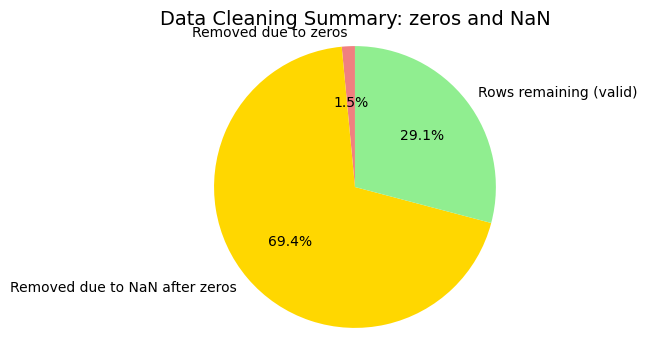

In [99]:
# Cantidades
total_rows = len(df_full_clean)
rows_no_zeros = len(df_no_zeros)
rows_no_nan = len(df_no_nan)
rows_with_nan_after_zero_removal = rows_no_zeros - rows_no_nan
rows_removed_zeros = total_rows - rows_no_zeros

# Etiquetas y valores para el pastel
labels = [
    "Removed due to zeros",
    "Removed due to NaN after zeros",
    "Rows remaining (valid)"
]
sizes = [
    rows_removed_zeros,
    rows_with_nan_after_zero_removal,
    rows_no_nan
]

# Colores
colors = ['lightcoral', 'gold', 'lightgreen']

# Crear figura
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Data Cleaning Summary: zeros and NaN", fontsize=14)
plt.axis('equal')  # Hace que el pie sea circular
plt.show()


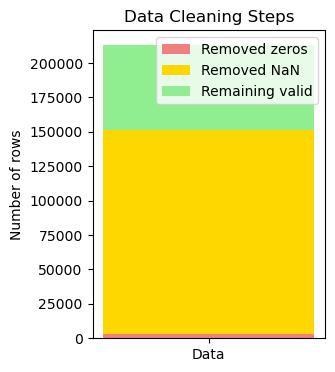

In [100]:

labels = ['Data']
removed_zeros = rows_removed_zeros
removed_nan = rows_with_nan_after_zero_removal
remaining = rows_no_nan
plt.figure(figsize=(3,4))
plt.bar(labels, [removed_zeros], color='lightcoral', label='Removed zeros')
plt.bar(labels, [removed_nan], bottom=[removed_zeros], color='gold', label='Removed NaN')
plt.bar(labels, [remaining], bottom=[removed_zeros + removed_nan], color='lightgreen', label='Remaining valid')
plt.ylabel('Number of rows')
plt.title('Data Cleaning Steps')
plt.legend()
plt.show()


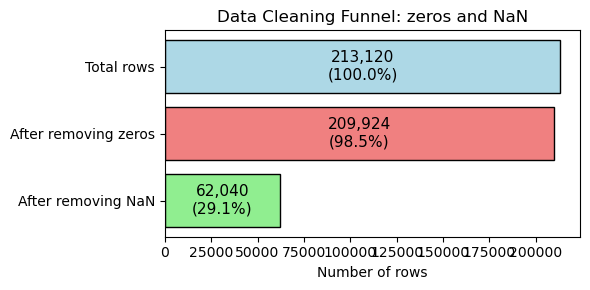

In [101]:
# Datos
steps = ['Total rows', 'After removing zeros', 'After removing NaN']
counts = [len(df_full_clean), len(df_no_zeros), len(df_no_nan)]
colors = ['lightblue', 'lightcoral', 'lightgreen']

# Crear figura
plt.figure(figsize=(6,3))

# Graficar barras horizontales
for i, (step, count, color) in enumerate(zip(steps, counts, colors)):
    plt.barh(y=i, width=count, color=color, edgecolor='black')
    # Mostrar número y porcentaje dentro de la barra
    percent = count / len(df_full_clean) * 100
    plt.text(count/2, i, f"{count:,}\n({percent:.1f}%)", va='center', ha='center', color='black', fontsize=11)

# Personalización
plt.yticks(range(len(steps)), steps)
plt.xlabel('Number of rows')
plt.title('Data Cleaning Funnel: zeros and NaN')
plt.gca().invert_yaxis()  # Opcional: que la barra más grande quede arriba
plt.tight_layout()
plt.show()


In [102]:
df_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62040 entries, 5 to 213112
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          62040 non-null  datetime64[ns]
 1   observatory   62040 non-null  object        
 2   xrsa          62040 non-null  float64       
 3   xrsb          62040 non-null  float64       
 4   xrsa_corr     62040 non-null  float64       
 5   xrsb_corr     62040 non-null  float64       
 6   T_cor         62040 non-null  float64       
 7   EM_cor        62040 non-null  float64       
 8   T_phot        62040 non-null  float64       
 9   EM_phot       62040 non-null  float64       
 10  EM_cor_norm   62040 non-null  float64       
 11  EM_phot_norm  62040 non-null  float64       
 12  day           62040 non-null  object        
 13  GOES_missing  62040 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(10), object(2)
memory usage: 6.7+ MB


In [103]:
df_no_nan.describe()

,date,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
count,62040,6.204000e+04,6.204000e+04,6.204000e+04,6.204000e+04,6.204000e+04,6.204000e+04,6.204000e+04,6.204000e+04,6.204000e+04,6.204000e+04
mean,2013-07-31 06:23:31.843326976,2.542958e-06,1.119378e-05,1.455333e-06,4.911471e-06,1.594353e+04,3.264405e+48,1.708035e+03,7.450892e+48,3.264405e-01,7.450892e-01
min,2000-06-06 00:05:00,1.000598e-09,2.164805e-09,3.552714e-15,5.684342e-14,1.329261e+00,3.534708e+25,1.297655e+00,3.676412e+29,3.534708e-24,3.676412e-20
25%,2003-06-15 02:16:45,3.860337e-08,1.566443e-06,5.005615e-09,5.670893e-08,7.607265e+00,6.642511e+46,6.675905e+00,1.820212e+47,6.642511e-03,1.820212e-02
50%,2013-11-05 22:12:30,9.660135e-08,2.753113e-06,1.861176e-08,1.859924e-07,1.070303e+01,1.776158e+47,9.619209e+00,4.976614e+47,1.776158e-02,4.976614e-02
75%,2024-02-16 22:07:15,3.089449e-07,5.279886e-06,9.022296e-08,6.968108e-07,1.342929e+01,4.907291e+47,1.264778e+01,1.384781e+48,4.907291e-02,1.384781e-01
max,2025-06-19 23:52:00,7.807088e-04,2.629195e-03,7.713941e-04,2.488573e-03,6.407996e+08,5.440151e+52,3.779645e+07,1.300871e+53,5.440151e+03,1.300871e+04
std,NaN,2.207222e-05,6.526745e-05,1.512014e-05,4.264424e-05,2.633847e+06,2.411327e+50,2.205624e+05,5.846261e+50,2.411327e+01,5.846261e+01


### Graphic data no NaN

In [104]:
def plot_comparison_scatter(df_list, x_cols, y_cols, titles=None, 
                           colors=None, x_scales=None, y_scales=None,
                           x_limits=None, y_limits=None, 
                           figsize=(10, 9), alpha=0.5, s=10):
    """
    Crea una cuadrícula de gráficos scatter para comparar múltiples DataFrames
    
    Parámetros:
    -----------
    df_list : list
        Lista de DataFrames a comparar
    x_cols : list
        Lista de columnas para el eje X (una por subplot)
    y_cols : list
        Lista de columnas para el eje Y (una por subplot)
    titles : list, optional
        Lista de títulos para cada DataFrame
    colors : list, optional
        Lista de colores para cada subplot
    x_scales : list, optional
        Lista de escalas para eje X ('linear', 'log', etc.)
    y_scales : list, optional
        Lista de escalas para eje Y ('linear', 'log', etc.)
    x_limits : list, optional
        Lista de tuplas con límites para eje X
    y_limits : list, optional
        Lista de tuplas con límites para eje Y
    figsize : tuple, optional
        Tamaño de la figura
    alpha : float, optional
        Transparencia de los puntos
    s : int, optional
        Tamaño de los puntos
    """
    
    n_dfs = len(df_list)
    n_plots = len(x_cols)
    
    # Valores por defecto
    if titles is None:
        titles = [f'DataFrame {i+1}' for i in range(n_dfs)]
    
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    if x_scales is None:
        x_scales = ['linear'] * n_plots
    
    if y_scales is None:
        y_scales = ['linear'] * n_plots
    
    # Crear figura
    fig, axes = plt.subplots(n_dfs, n_plots, figsize=figsize)
    
    # Asegurar que axes sea siempre 2D
    if n_dfs == 1:
        axes = axes.reshape(1, -1)
    if n_plots == 1:
        axes = axes.reshape(-1, 1)
    
    # Generar plots
    for i, df in enumerate(df_list):
        for j in range(n_plots):
            ax = axes[i, j]
            
            # Scatter plot
            ax.scatter(df[x_cols[j]], df[y_cols[j]], 
                      s=s, alpha=alpha, color=colors[j],
                      label=f'{x_cols[j]} vs {y_cols[j]}')
            
            # Configurar escalas
            ax.set_xscale(x_scales[j])
            ax.set_yscale(y_scales[j])
            
            # Configurar límites
            if x_limits and x_limits[j]:
                ax.set_xlim(x_limits[j])
            if y_limits and y_limits[j]:
                ax.set_ylim(y_limits[j])
            
            # Etiquetas y título
            ax.set_xlabel(x_cols[j], fontsize=12)
            ax.set_ylabel(y_cols[j], fontsize=12)
            ax.set_title(f'{titles[i]}: {x_cols[j]} vs {y_cols[j]}', fontsize=14)
            
            # Grid y leyenda
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.legend()
    
    plt.tight_layout()
    plt.show()


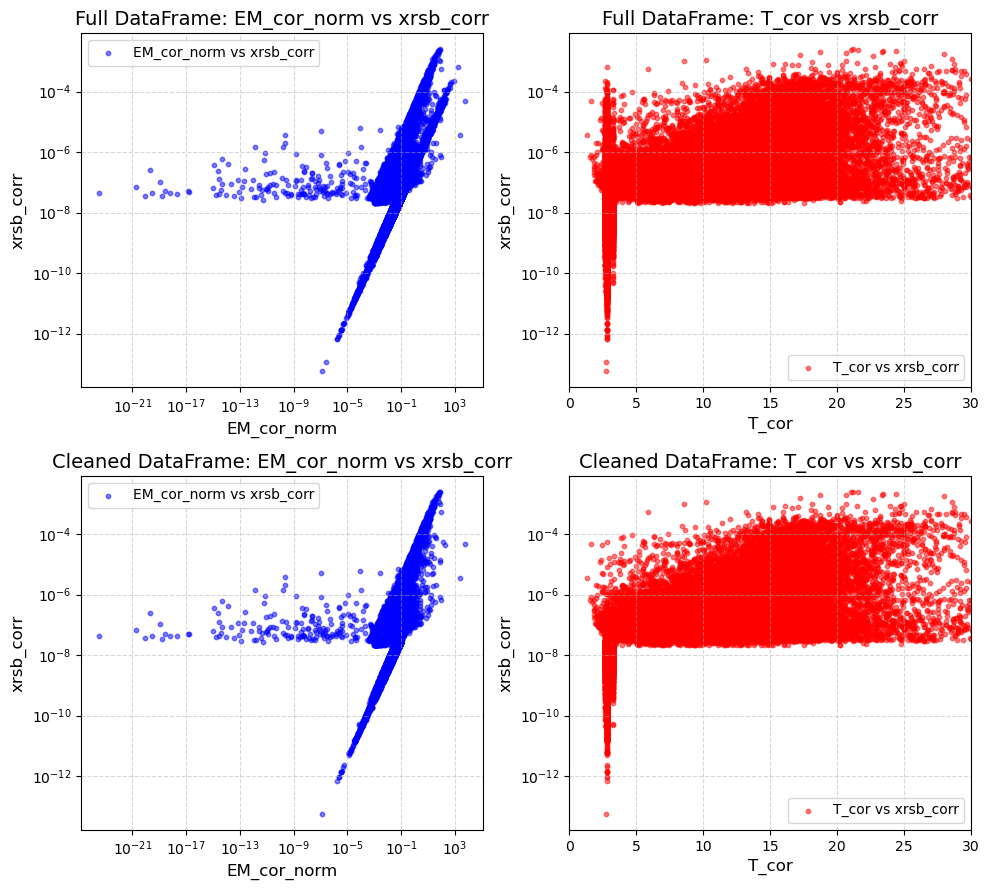

In [105]:
plot_comparison_scatter(
        df_list=[df_full_clean, df_no_nan],
        x_cols=['EM_cor_norm', 'T_cor'],
        y_cols=['xrsb_corr', 'xrsb_corr'],
        titles=['Full DataFrame', 'Cleaned DataFrame'],
        colors=['blue', 'red'],
        x_scales=['log', 'linear'],
        y_scales=['log', 'log'],
        x_limits=[None, (0, 30)],
        figsize=(10, 9)
    )

### Filter 3. repeating temperature data

In [106]:
T_MK = df_no_nan['T_cor'] 

# Contar repeticiones exactas
counts = T_MK.value_counts().head(18)  # los 10 valores que más se repiten
print(counts)

T_cor
2.795147     3132
2.811526     2865
2.750396     1305
2.667883     1096
3.269362      643
2.825434      352
2.797938      101
13.782039       3
11.004897       2
9.755634        2
6.639702        2
12.536558       2
9.531494        2
12.399574       2
12.330120       2
10.592699       2
11.259432       2
10.496259       2
Name: count, dtype: int64


In [107]:
#Count how many times each T_cor value appears

T_counts = df_no_nan['T_cor'].value_counts()

# Identify repetition categories

once_count = (T_counts == 1).sum()
twice_count = (T_counts == 2).sum()
more_than_twice_count = (T_counts > 2).sum()

# Filter out values repeated 
repeat_filter = 1
repeated_T_values = T_counts[T_counts > repeat_filter].index
df_no_repeated = df_no_nan[~df_no_nan['T_cor'].isin(repeated_T_values)]

# Calculate summary statistics

total_original = len(df_no_nan)
removed_repeated = total_original - len(df_no_repeated)
remaining_rows = len(df_no_repeated)

percent_removed_repeated = (removed_repeated / total_original) * 100
percent_remaining_repeated = (remaining_rows / total_original) * 100

# Print results

print(f"🔹 T_cor values appearing once: {once_count:,}")
print(f"🔹 T_cor values appearing twice: {twice_count:,}")
print(f"🔹 T_cor values appearing more than twice (removed): {more_than_twice_count:,}\n")

print(f"✅ Rows removed due to repeated (filter={repeat_filter}) T_cor values: {removed_repeated:,} ({percent_removed_repeated:.2f}% of df_no_nan)")
print(f"Rows remaining after removing repetitions: {remaining_rows:,} ({percent_remaining_repeated:.2f}% of df_no_nan)")

print(
"\n⚠️ Note: Only rows with unique T_cor values were kept.\n"
"All temperatures that appeared more than once were removed to avoid redundancy."
)

🔹 T_cor values appearing once: 52,483
🔹 T_cor values appearing twice: 30
🔹 T_cor values appearing more than twice (removed): 8

✅ Rows removed due to repeated (filter=1) T_cor values: 9,557 (15.40% of df_no_nan)
Rows remaining after removing repetitions: 52,483 (84.60% of df_no_nan)

⚠️ Note: Only rows with unique T_cor values were kept.
All temperatures that appeared more than once were removed to avoid redundancy.


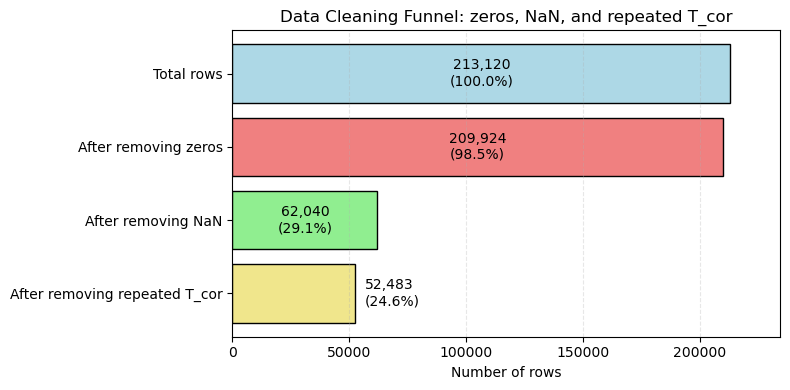

Data Cleaning Summary:
Total rows: 213,120 rows (100.0%)
After removing zeros: 209,924 rows (98.5%)
After removing NaN: 62,040 rows (29.1%)
After removing repeated T_cor: 52,483 rows (24.6%)


In [108]:
steps = ['Total rows', 'After removing zeros', 'After removing NaN', 'After removing repeated T_cor']
counts = [len(df_full_clean), len(df_no_zeros), len(df_no_nan), len(df_no_repeated)]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'khaki']

# Create figure
plt.figure(figsize=(8, 4))

# Plot horizontal bars
bars = plt.barh(range(len(steps)), counts, color=colors, edgecolor='black')

# Customize plot
plt.yticks(range(len(steps)), steps)
plt.xlabel('Number of rows')
plt.title('Data Cleaning Funnel: zeros, NaN, and repeated T_cor')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Calculate percentages
percentages = [count / len(df_full_clean) * 100 for count in counts]

# Smart placement based on bar size
for i, (bar, count, percent) in enumerate(zip(bars, counts, percentages)):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    
    # Use relative threshold (25% of maximum bar width)
    width_ratio = width / max(counts)
    
    if width_ratio > 0.25:  # Adjust this value as needed
        # Place inside (centered) for wide bars
        plt.text(width / 2, y_pos, f"{count:,}\n({percent:.1f}%)", 
                 va='center', ha='center', color='black', fontsize=10, fontweight='normal')
    else:
        # Place to the RIGHT for narrow bars
        label_x = width + (max(counts) * 0.02)
        plt.text(label_x, y_pos, f"{count:,}\n({percent:.1f}%)", 
                 va='center', ha='left', color='black', fontsize=10, fontweight='normal')

# Adjust x-axis limit
max_count = max(counts)
plt.xlim(0, max_count * 1.1)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Data Cleaning Summary:")
print("======================")
for i, (step, count) in enumerate(zip(steps, counts)):
    percent = count / len(df_full_clean) * 100
    print(f"{step}: {count:,} rows ({percent:.1f}%)")

### Graphs valid

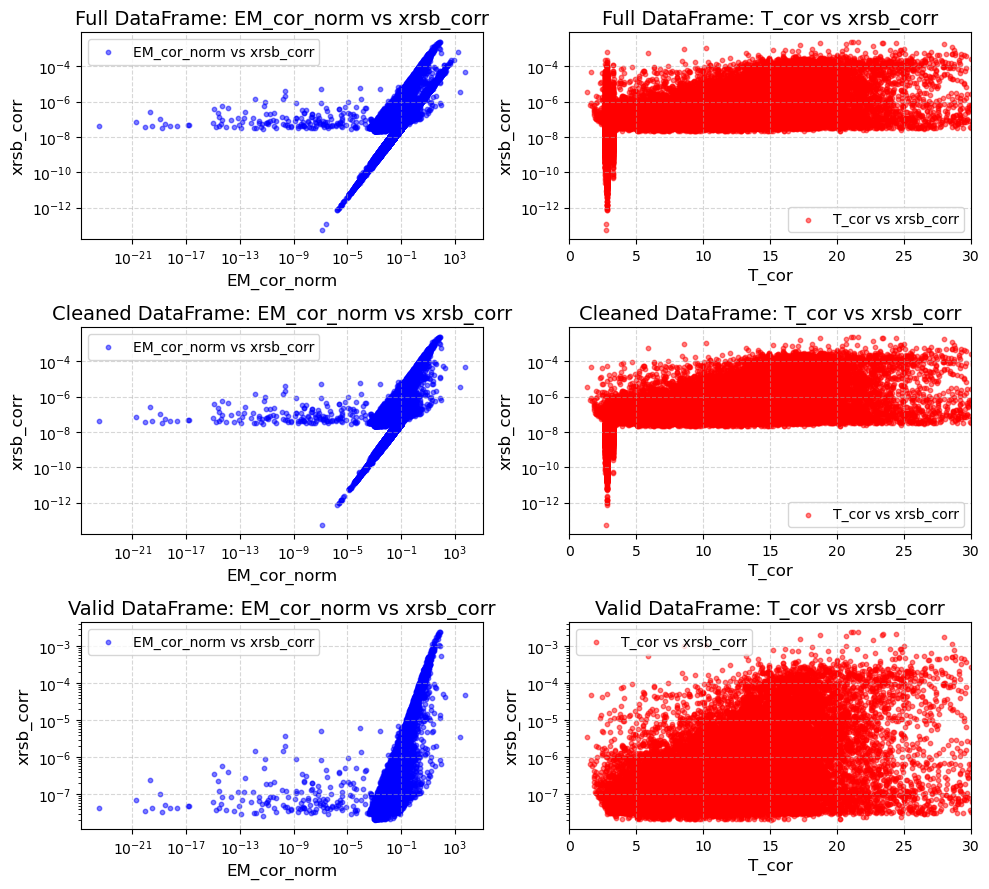

In [109]:
# Definir parámetros
dataframes = [df_full_clean, df_no_nan, df_no_repeated]  # Tus DataFrames
nombres = ['Full DataFrame', 'Cleaned DataFrame', 'Valid DataFrame']
    
columnas_x = ['EM_cor_norm', 'T_cor']  # Columnas para eje X
columnas_y = ['xrsb_corr', 'xrsb_corr']  # Columnas para eje Y

escalas_x = ['log', 'linear']  # Escalas para eje X
escalas_y = ['log', 'log']     # Escalas para eje Y

limites_x = [None, (0, 30)]    # Límites para eje X
limites_y = [None, None]       # Límites para eje Y

colores = ['blue', 'red']      # Colores para cada subplot

# Llamar a la función
plot_comparison_scatter(
    df_list=dataframes,
    x_cols=columnas_x,
    y_cols=columnas_y,
    titles=nombres,
    colors=colores,
    x_scales=escalas_x,
    y_scales=escalas_y,
    x_limits=limites_x,
    y_limits=limites_y,
    figsize=(10, 9),
    alpha=0.5,
    s=10)

### graphics with mask

In [110]:
def plot_with_external_mask(df, x_cols, y_cols, mask, mask_labels=None, colors=None, 
                           titles=None, x_scales=None, y_scales=None, x_limits=None, 
                           y_limits=None, figsize=(12, 10), alpha=0.3, s=10):
    """
    Create scatter plot grid comparing data with and without an external mask.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Main DataFrame to plot
    x_cols : list
        List of columns for X axis (one per subplot)
    y_cols : list  
        List of columns for Y axis (one per subplot)
    mask : pandas.Series or array-like
        Boolean mask where True values will be highlighted
    mask_labels : list, optional
        Labels for masked and unmasked data. Default: ['Masked data', 'Non-masked data']
    colors : list, optional  
        Colors for masked and unmasked data. Default: ['red', 'blue']
    titles : list, optional
        Custom titles for each subplot
    x_scales : list, optional
        Scale for X axis ('linear', 'log') for each subplot
    y_scales : list, optional
        Scale for Y axis ('linear', 'log') for each subplot  
    x_limits : list, optional
        X axis limits as tuples for each subplot
    y_limits : list, optional
        Y axis limits as tuples for each subplot
    figsize : tuple, optional
        Figure size
    alpha : float, optional
        Point transparency
    s : int, optional
        Point size
    """
    
    n_plots = len(x_cols)
    
    # Set default values
    if mask_labels is None:
        mask_labels = ['Masked data', 'Non-masked data']
    
    if colors is None:
        colors = ['red', 'blue']
    
    if titles is None:
        titles = [f'{y_col} vs {x_col}' for x_col, y_col in zip(x_cols, y_cols)]
    
    if x_scales is None:
        x_scales = ['linear'] * n_plots
    
    if y_scales is None:
        y_scales = ['linear'] * n_plots
    
    # Split data using the external mask
    df_masked = df[mask]       # Data where mask is True (highlighted)
    df_non_masked = df[~mask]  # Data where mask is False (normal)
    
    print(f"Masked data: {len(df_masked)} rows")
    print(f"Non-masked data: {len(df_non_masked)} rows")
    
    # Create figure with subplots
    n_rows = int(np.ceil(n_plots / 2))  # Auto-calculate rows
    n_cols = min(2, n_plots)  # Max 2 columns
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single subplot case
    if n_plots == 1:
        axes = np.array([axes])
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easy iteration
    axes_flat = axes.flatten()
    
    # Create plots
    for i, (x_col, y_col) in enumerate(zip(x_cols, y_cols)):
        ax = axes_flat[i]
        
        # --- Create scatter plots ---
        # Plot non-masked data first (background)
        ax.scatter(df_non_masked[x_col], df_non_masked[y_col], 
                  s=s, alpha=alpha, color=colors[1], label=mask_labels[1])
        
        # Plot masked data on top (highlighted)
        ax.scatter(df_masked[x_col], df_masked[y_col], 
                  s=s, alpha=alpha, color=colors[0], label=mask_labels[0])
        
        # --- Configure axes ---
        ax.set_xscale(x_scales[i])
        ax.set_yscale(y_scales[i])
        
        if x_limits and i < len(x_limits) and x_limits[i]:
            ax.set_xlim(x_limits[i])
        if y_limits and i < len(y_limits) and y_limits[i]:
            ax.set_ylim(y_limits[i])
        
        # Labels and title
        ax.set_xlabel(x_col, fontsize=12)
        ax.set_ylabel(y_col, fontsize=12)
        ax.set_title(titles[i], fontsize=14)
        
        # Grid and legend
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.legend()
    
    # Hide empty subplots
    for i in range(n_plots, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

# Function to create frequency mask (you can use this outside)
def create_frequency_mask(df, column, threshold=1):
    """
    Create a mask for frequent values in a column.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    column : str
        Column name to analyze
    threshold : int
        Values with count > threshold will be masked as True
        
    Returns:
    --------
    mask : pandas.Series
        Boolean mask where True indicates frequent values
    """
    value_counts = df[column].value_counts()
    frequent_values = value_counts[value_counts > threshold].index
    mask = df[column].isin(frequent_values)
    
    print(f"Frequent values in {column}: {len(frequent_values)}")
    print(f"Masked data: {mask.sum()} rows")
    print(f"Non-masked data: {(~mask).sum()} rows")
    
    return mask




In [111]:
mask1 = create_frequency_mask(df=df_no_nan, column='T_cor', threshold=1)


Frequent values in T_cor: 38
Masked data: 9557 rows
Non-masked data: 52483 rows


In [112]:
def plot_with_mask_comparison(df, mask, x_cols, y_cols, titles=None, 
                             mask_labels=None, colors=None, x_scales=None, y_scales=None,
                             x_limits=None, y_limits=None, figsize=(12, 6), alpha=0.5, s=10):
    """
    Create scatter plots comparing masked vs non-masked data with flexible configuration.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Main DataFrame to plot
    mask : pandas.Series
        Boolean mask where True indicates the special data points to highlight
    x_cols : list
        List of columns for X axis (one per subplot)
    y_cols : list  
        List of columns for Y axis (one per subplot)
    titles : list, optional
        Custom titles for each subplot
    mask_labels : list, optional
        Labels for masked and unmasked data. Default: ['Masked data', 'Non-masked data']
    colors : list, optional  
        Colors for masked and unmasked data. Default: ['red', 'blue']
    x_scales : list, optional
        Scale for X axis ('linear', 'log') for each subplot
    y_scales : list, optional
        Scale for Y axis ('linear', 'log') for each subplot  
    x_limits : list, optional
        X axis limits as tuples for each subplot
    y_limits : list, optional
        Y axis limits as tuples for each subplot
    figsize : tuple, optional
        Figure size
    alpha : float, optional
        Point transparency
    s : int, optional
        Point size
    """
    
    n_plots = len(x_cols)
    
    # Set default values
    if mask_labels is None:
        mask_labels = ['Masked data', 'Non-masked data']
    
    if colors is None:
        colors = ['red', 'blue']
    
    if titles is None:
        titles = [f'{y_col} vs {x_col}' for x_col, y_col in zip(x_cols, y_cols)]
    
    if x_scales is None:
        x_scales = ['linear'] * n_plots
    
    if y_scales is None:
        y_scales = ['linear'] * n_plots
    
    # Split data using the mask
    df_masked = df[mask]       # Data where mask is True (highlighted)
    df_non_masked = df[~mask]  # Data where mask is False (normal)
    
    print(f"Masked data: {len(df_masked)} rows")
    print(f"Non-masked data: {len(df_non_masked)} rows")
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    # Handle single subplot case
    if n_plots == 1:
        axes = [axes]
    
    # Create plots
    for i, (x_col, y_col) in enumerate(zip(x_cols, y_cols)):
        ax = axes[i]
        
        # --- Create scatter plots ---
        # Plot non-masked data first (background)
        ax.scatter(df_non_masked[x_col], df_non_masked[y_col], 
                  s=s, alpha=alpha, color=colors[1], label=mask_labels[1])
        
        # Plot masked data on top (highlighted)
        ax.scatter(df_masked[x_col], df_masked[y_col], 
                  s=s, alpha=alpha, color=colors[0], label=mask_labels[0])
        
        # --- Configure axes ---
        ax.set_xscale(x_scales[i])
        ax.set_yscale(y_scales[i])
        
        if x_limits and i < len(x_limits) and x_limits[i]:
            ax.set_xlim(x_limits[i])
        if y_limits and i < len(y_limits) and y_limits[i]:
            ax.set_ylim(y_limits[i])
        
        # Labels and title
        ax.set_xlabel(x_col, fontsize=12)
        ax.set_ylabel(y_col, fontsize=12)
        ax.set_title(titles[i], fontsize=14)
        
        # Grid and legend
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

Masked data: 9557 rows
Non-masked data: 52483 rows


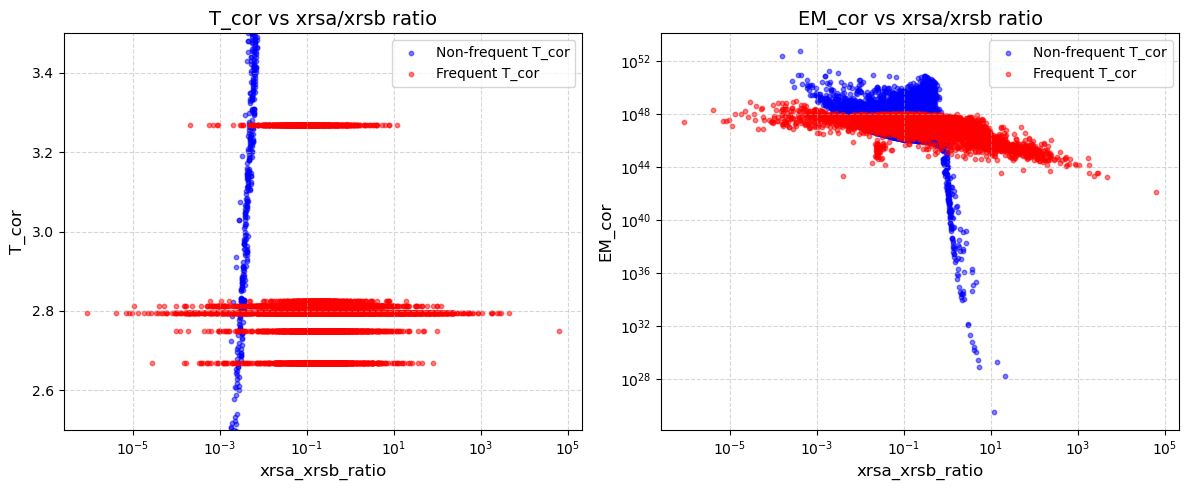

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'T_cor vs xrsa/xrsb ratio'}, xlabel='xrsa_xrsb_ratio', ylabel='T_cor'>,
        <Axes: title={'center': 'EM_cor vs xrsa/xrsb ratio'}, xlabel='xrsa_xrsb_ratio', ylabel='EM_cor'>],
       dtype=object))

In [113]:
# Datos que se repiten mucho
df_topT = df_no_nan[mask1]

# Datos restantes
df_other = df_no_nan[~mask1]

# Calcular la razón xrsa_corr / xrsb_corr
ratio_other = df_other['xrsa_corr'] / df_other['xrsb_corr']
ratio_topT = df_topT['xrsa_corr'] / df_topT['xrsb_corr']

# Agregar como nueva columna a los DataFrames
df_other = df_other.copy()  # Para evitar SettingWithCopyWarning
df_topT = df_topT.copy()
df_other['xrsa_xrsb_ratio'] = ratio_other
df_topT['xrsa_xrsb_ratio'] = ratio_topT

# Combinar los DataFrames para usar en la función - RESETEAR ÍNDICES
df_combined = pd.concat([df_other, df_topT], ignore_index=True)

# Crear máscara con el mismo índice que df_combined
mask_combined = pd.Series([False] * len(df_other) + [True] * len(df_topT))

# Usar la función con la nueva columna
plot_with_mask_comparison(
    df=df_combined,
    mask=mask_combined,
    x_cols=['xrsa_xrsb_ratio', 'xrsa_xrsb_ratio'],  # Usar el ratio en X
    y_cols=['T_cor', 'EM_cor'],                     # Y columns
    titles=['T_cor vs xrsa/xrsb ratio', 'EM_cor vs xrsa/xrsb ratio'],
    mask_labels=['Frequent T_cor', 'Non-frequent T_cor'],
    colors=['red', 'blue'],
    x_scales=['log', 'log'],
    y_scales=['linear', 'log'],  # EM_cor debería ser log
    x_limits=[None, None],
    y_limits=[(2.5, 3.5), None],
    figsize=(12, 5)
)

In [114]:
def plot_two_dataframes_comparison(df1, df2, x_cols, y_cols, df1_label='DataFrame 1', df2_label='DataFrame 2',
                                  titles=None, colors=None, x_scales=None, y_scales=None,
                                  x_limits=None, y_limits=None, figsize=(12, 6), alpha=0.5, s=10):
    """
    Create scatter plots comparing two DataFrames with flexible configuration.
    
    Parameters:
    -----------
    df1 : pandas.DataFrame
        First DataFrame to plot
    df2 : pandas.DataFrame  
        Second DataFrame to plot
    x_cols : list
        List of columns for X axis (one per subplot)
    y_cols : list  
        List of columns for Y axis (one per subplot)
    df1_label : str, optional
        Label for first DataFrame in legend
    df2_label : str, optional
        Label for second DataFrame in legend
    titles : list, optional
        Custom titles for each subplot
    colors : list, optional  
        Colors for df1 and df2. Default: ['blue', 'red']
    x_scales : list, optional
        Scale for X axis ('linear', 'log') for each subplot
    y_scales : list, optional
        Scale for Y axis ('linear', 'log') for each subplot  
    x_limits : list, optional
        X axis limits as tuples for each subplot
    y_limits : list, optional
        Y axis limits as tuples for each subplot
    figsize : tuple, optional
        Figure size
    alpha : float, optional
        Point transparency
    s : int, optional
        Point size
    """
    
    n_plots = len(x_cols)
    
    # Set default values
    if colors is None:
        colors = ['blue', 'red']
    
    if titles is None:
        titles = [f'{y_col} vs {x_col}' for x_col, y_col in zip(x_cols, y_cols)]
    
    if x_scales is None:
        x_scales = ['linear'] * n_plots
    
    if y_scales is None:
        y_scales = ['linear'] * n_plots
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    # Handle single subplot case
    if n_plots == 1:
        axes = [axes]
    
    # Create plots
    for i, (x_col, y_col) in enumerate(zip(x_cols, y_cols)):
        ax = axes[i]
        
        # --- Create scatter plots ---
        # Plot df1 first
        ax.scatter(df1[x_col], df1[y_col], 
                  s=s, alpha=alpha, color=colors[0], label=df1_label)
        
        # Plot df2 on top
        ax.scatter(df2[x_col], df2[y_col], 
                  s=s, alpha=alpha, color=colors[1], label=df2_label)
        
        # --- Configure axes ---
        ax.set_xscale(x_scales[i])
        ax.set_yscale(y_scales[i])
        
        if x_limits and i < len(x_limits) and x_limits[i]:
            ax.set_xlim(x_limits[i])
        if y_limits and i < len(y_limits) and y_limits[i]:
            ax.set_ylim(y_limits[i])
        
        # Labels and title
        ax.set_xlabel(x_col, fontsize=12)
        ax.set_ylabel(y_col, fontsize=12)
        ax.set_title(titles[i], fontsize=14)
        
        # Grid and legend
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

### Filter 4. outliers

In [115]:
df_no_repeated["T_cor"].describe()

count    5.248300e+04
mean     1.884627e+04
std      2.863626e+06
min      1.329261e+00
25%      9.294596e+00
50%      1.147913e+01
75%      1.398784e+01
max      6.407996e+08
Name: T_cor, dtype: float64

In [116]:
# Asumo que ya tienes df_no_repeated con columna 'T_cor' en MK (o conviértela a MK)
# Si T_cor está en K, divide por 1e6 primero:
# df_no_repeated['T_cor_MK'] = df_no_repeated['T_cor'] / 1e6

col = 'T_cor'            # si ya está en MK; si está en K usar 'T_cor_MK' tras conversión
total = len(df_no_repeated)

# Umbrales en MK
t1 = 50.0   # límite práctico confiable
t2 = 100.0  # límite de plausibilidad extrema

n_le_50  = df_no_repeated[df_no_repeated[col] <= t1].shape[0]
n_50_100 = df_no_repeated[(df_no_repeated[col] > t1) & (df_no_repeated[col] <= t2)].shape[0]
n_gt_100 = df_no_repeated[df_no_repeated[col] > t2].shape[0]

print(f"Total filas: {total:,}")
print(f"<= {t1:.0f} MK: {n_le_50:,} ({n_le_50/total*100:.3f}%)")
print(f"{t1:.0f}–{t2:.0f} MK: {n_50_100:,} ({n_50_100/total*100:.3f}%)")
print(f"> {t2:.0f} MK: {n_gt_100:,} ({n_gt_100/total*100:.6f}%)")

# Mostrar los 5 máximos para inspección
print("\n5 valores máximos de T_cor (revisar estos casos):")
print(df_no_repeated.nlargest(5, col)[['date', col, 'xrsa', 'xrsb']])

# Opcional: marcar como 'suspect' si >50 MK
df_checked = df_no_repeated.copy()
df_checked['T_cor_flag'] = 'ok'
df_checked.loc[df_checked[col] > t1, 'T_cor_flag'] = 'suspect'
df_checked.loc[df_checked[col] > t2, 'T_cor_flag'] = 'remove'  # o 'artifact' según prefieras


Total filas: 52,483
<= 50 MK: 52,235 (99.527%)
50–100 MK: 60 (0.114%)
> 100 MK: 188 (0.358211%)

5 valores máximos de T_cor (revisar estos casos):
                      date         T_cor          xrsa      xrsb
173888 2024-05-14 18:08:00  6.407996e+08  4.063712e-06  0.000039
838    2000-06-06 13:58:00  1.063431e+08  4.319949e-06  0.000032
18804  2001-10-19 01:24:00  6.305443e+07  1.488391e-05  0.000084
166217 2024-05-08 10:17:00  4.456965e+07  1.356629e-06  0.000014
168416 2024-05-09 22:56:00  3.223104e+07  6.894771e-07  0.000011


In [117]:
df_checked

,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,day,GOES_missing,T_cor_flag
5,2000-06-06 00:05:00,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513,2000-06-06,False,ok
6,2000-06-06 00:06:00,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867,2000-06-06,False,ok
7,2000-06-06 00:07:00,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856,2000-06-06,False,ok
8,2000-06-06 00:08:00,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692,2000-06-06,False,ok
9,2000-06-06 00:09:00,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455,2000-06-06,False,ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213108,2025-06-19 23:48:00,GOES-18,3.405156e-05,1.143163e-04,3.399457e-05,1.125468e-04,16.657396,3.804183e+49,16.523401,7.395706e+49,3.804183,7.395706,2025-06-19,False,ok
213109,2025-06-19 23:49:00,GOES-18,5.181752e-05,1.654751e-04,5.171337e-05,1.633881e-04,17.078171,5.438753e+49,17.055769,1.038429e+50,5.438753,10.384291,2025-06-19,False,ok
213110,2025-06-19 23:50:00,GOES-18,5.891791e-05,1.902050e-04,5.853312e-05,1.864586e-04,17.002618,6.223557e+49,16.959690,1.192080e+50,6.223557,11.920796,2025-06-19,False,ok
213111,2025-06-19 23:51:00,GOES-18,5.066445e-05,1.751783e-04,4.736253e-05,1.579830e-04,16.592150,5.352916e+49,16.441442,1.043633e+50,5.352916,10.436329,2025-06-19,False,ok


In [118]:
# Definir filtro físico para T_cor (en millones de kelvin)
lower_limit = 1   # 1 MK
upper_limit = 100   # 100 MK

# Aplicar filtro
df_Tcor_valid = df_no_repeated[
    (df_no_repeated["T_cor"] >= lower_limit) &
    (df_no_repeated["T_cor"] <= upper_limit)
]

# Calcular totales
total = len(df_no_repeated)
valid = len(df_Tcor_valid)
removed = total - valid
percent_removed = (removed / total) * 100

# Mostrar resumen
print(f"Filtro aplicado: {lower_limit} ≤ T_cor ≤ {upper_limit}")
print(f"Total inicial: {total:,}")
print(f"Filas eliminadas: {removed:,} ({percent_removed:.2f}%)")
print(f"Filas restantes: {valid:,}")

Filtro aplicado: 1 ≤ T_cor ≤ 100
Total inicial: 52,483
Filas eliminadas: 188 (0.36%)
Filas restantes: 52,295


In [119]:
df_Tcor_valid["T_cor"].describe()

count    52295.000000
mean        11.995026
std          4.706075
min          1.329261
25%          9.284730
50%         11.465188
75%         13.951802
max         99.432467
Name: T_cor, dtype: float64

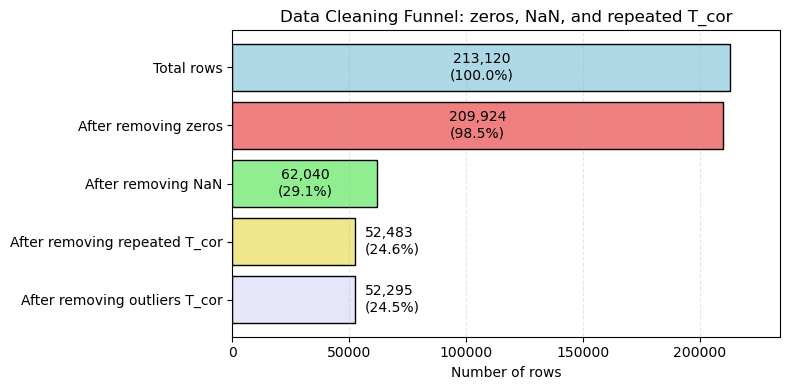

Data Cleaning Summary:
Total rows: 213,120 rows (100.0%)
After removing zeros: 209,924 rows (98.5%)
After removing NaN: 62,040 rows (29.1%)
After removing repeated T_cor: 52,483 rows (24.6%)
After removing outliers T_cor: 52,295 rows (24.5%)


In [120]:
steps = ['Total rows', 'After removing zeros', 'After removing NaN', 'After removing repeated T_cor', 'After removing outliers T_cor' ]
counts = [len(df_full_clean), len(df_no_zeros), len(df_no_nan), len(df_no_repeated), len(df_Tcor_valid)]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'khaki', 'lavender']

# Create figure
plt.figure(figsize=(8, 4))

# Plot horizontal bars
bars = plt.barh(range(len(steps)), counts, color=colors, edgecolor='black')

# Customize plot
plt.yticks(range(len(steps)), steps)
plt.xlabel('Number of rows')
plt.title('Data Cleaning Funnel: zeros, NaN, and repeated T_cor')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Calculate percentages
percentages = [count / len(df_full_clean) * 100 for count in counts]

# Smart placement based on bar size
for i, (bar, count, percent) in enumerate(zip(bars, counts, percentages)):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    
    # Use relative threshold (25% of maximum bar width)
    width_ratio = width / max(counts)
    
    if width_ratio > 0.25:  # Adjust this value as needed
        # Place inside (centered) for wide bars
        plt.text(width / 2, y_pos, f"{count:,}\n({percent:.1f}%)", 
                 va='center', ha='center', color='black', fontsize=10, fontweight='normal')
    else:
        # Place to the RIGHT for narrow bars
        label_x = width + (max(counts) * 0.02)
        plt.text(label_x, y_pos, f"{count:,}\n({percent:.1f}%)", 
                 va='center', ha='left', color='black', fontsize=10, fontweight='normal')

# Adjust x-axis limit
max_count = max(counts)
plt.xlim(0, max_count * 1.1)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Data Cleaning Summary:")
print("======================")
for i, (step, count) in enumerate(zip(steps, counts)):
    percent = count / len(df_full_clean) * 100
    print(f"{step}: {count:,} rows ({percent:.1f}%)")

## Valid GOES Data 

In [121]:
df_full_valid = df_Tcor_valid
df_full_valid["GOES_ID"] = ["GOES_" + str(i) for i in range(len(df_full_valid))]
df_full_valid.head()

/tmp/ipykernel_10624/3891087627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_valid["GOES_ID"] = ["GOES_" + str(i) for i in range(len(df_full_valid))]


,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm,day,GOES_missing,GOES_ID
5,2000-06-06 00:05:00,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513,2000-06-06,False,GOES_0
6,2000-06-06 00:06:00,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867,2000-06-06,False,GOES_1
7,2000-06-06 00:07:00,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856,2000-06-06,False,GOES_2
8,2000-06-06 00:08:00,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692,2000-06-06,False,GOES_3
9,2000-06-06 00:09:00,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455,2000-06-06,False,GOES_4


## confirmación de # de días

In [122]:
# por confirmar el número de días
df_full_valid["day"] = df_full_valid["date"].dt.date

new_n = df_full_valid['day'].nunique()
new_n

/tmp/ipykernel_10624/1529140388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_valid["day"] = df_full_valid["date"].dt.date


148

In [123]:
# Definir el nuevo orden de columnas
new_order = [
    "GOES_ID", "date",	"day", "observatory",	"xrsa",	"xrsb",	"xrsa_corr",	"xrsb_corr",
    "T_cor",	"EM_cor",	"T_phot",	"EM_phot",	"EM_cor_norm",	"EM_phot_norm"
]
# Reordenar el DataFrame
df_full_valid = df_full_valid[new_order]

df_full_valid.head()

,GOES_ID,date,day,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
5,GOES_0,2000-06-06 00:05:00,2000-06-06,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513
6,GOES_1,2000-06-06 00:06:00,2000-06-06,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867
7,GOES_2,2000-06-06 00:07:00,2000-06-06,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856
8,GOES_3,2000-06-06 00:08:00,2000-06-06,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692
9,GOES_4,2000-06-06 00:09:00,2000-06-06,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455


## Guardar df_full_valid

In [124]:
output_path = os.path.join(output_dir, f"df_full_{new_n}_valid.csv")
df_full_valid.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: Data_for_185_days/df_full_148_valid.csv


In [125]:
df_full_valid.info()                           # type: ignore

<class 'pandas.core.frame.DataFrame'>
Index: 52295 entries, 5 to 213112
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   GOES_ID       52295 non-null  object        
 1   date          52295 non-null  datetime64[ns]
 2   day           52295 non-null  object        
 3   observatory   52295 non-null  object        
 4   xrsa          52295 non-null  float64       
 5   xrsb          52295 non-null  float64       
 6   xrsa_corr     52295 non-null  float64       
 7   xrsb_corr     52295 non-null  float64       
 8   T_cor         52295 non-null  float64       
 9   EM_cor        52295 non-null  float64       
 10  T_phot        52295 non-null  float64       
 11  EM_phot       52295 non-null  float64       
 12  EM_cor_norm   52295 non-null  float64       
 13  EM_phot_norm  52295 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(3)
memory usage: 6.0+ MB


In [126]:
df_full_valid


,GOES_ID,date,day,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
5,GOES_0,2000-06-06 00:05:00,2000-06-06,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513
6,GOES_1,2000-06-06 00:06:00,2000-06-06,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867
7,GOES_2,2000-06-06 00:07:00,2000-06-06,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856
8,GOES_3,2000-06-06 00:08:00,2000-06-06,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692
9,GOES_4,2000-06-06 00:09:00,2000-06-06,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213108,GOES_52290,2025-06-19 23:48:00,2025-06-19,GOES-18,3.405156e-05,1.143163e-04,3.399457e-05,1.125468e-04,16.657396,3.804183e+49,16.523401,7.395706e+49,3.804183,7.395706
213109,GOES_52291,2025-06-19 23:49:00,2025-06-19,GOES-18,5.181752e-05,1.654751e-04,5.171337e-05,1.633881e-04,17.078171,5.438753e+49,17.055769,1.038429e+50,5.438753,10.384291
213110,GOES_52292,2025-06-19 23:50:00,2025-06-19,GOES-18,5.891791e-05,1.902050e-04,5.853312e-05,1.864586e-04,17.002618,6.223557e+49,16.959690,1.192080e+50,6.223557,11.920796
213111,GOES_52293,2025-06-19 23:51:00,2025-06-19,GOES-18,5.066445e-05,1.751783e-04,4.736253e-05,1.579830e-04,16.592150,5.352916e+49,16.441442,1.043633e+50,5.352916,10.436329
